In [10]:
# Imports, setup

In [11]:
import numpy as np
from scipy import stats, interpolate, optimize
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('latex_thesis')
%matplotlib inline

# Restore matplotlib 1.x color cycler
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from multihist import Histdd, Hist1d
import xeshape as xs
import blueice as bi

# Only need it for cuts and misc stuff, no need to init
from hax import cuts
from hax.misc import draw_box

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [12]:
# Time coordinates of waveform matrix
dt = 10
ts = np.arange(-125, 125 +1) * 10

# Test for SPE offsets
# def bla_pulse(t):
#     return stats.uniform(0, 10).cdf(t)
# pwvs = xs.simulate_peak_waveforms(np.zeros(1e4), ts, bla_pulse, stats.norm(100, 10), n_offsets=4)
# plt.plot(ts, pwvs[:, 0], linestyle='steps-mid')
# plt.xlim(-100, 100)

In [13]:
# Waveform plot with inset that zooms to low-amplitude region
def inset_plot(plot_orders, 
               xlabel='Time (ns) since 10\% area sample', 
               ylabel='Mean amplitude (fraction of total)',
               inset_zoom=0.06,
               inset_log=True,
               inset_lims=None
              ):
    plot_orders()
    plt.grid(alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    leg = plt.legend(bbox_to_anchor=(0., .1, 1, .1))
    if leg is not None:
        leg.get_frame().set_linewidth(0.0)
        leg.get_frame().set_alpha(0.85)

    plt.xlim(*t_range)

    ax = plt.axes([.5, .55, .4, .35])
    plt.sca(ax)
    plot_orders()
    if inset_log:
        plt.yscale('log')
    if inset_lims:
        plt.ylim(*inset_lims)
    else:
        plt.ylim(*(np.array(plt.ylim()) * inset_zoom))
    plt.grid(alpha=0.2)
    plt.xlim(*t_range)
    #plt.text(150, 0.025, 'Zoom-in')
    plt.tight_layout()
    
# Lines with labels on the plot
def labeled_vline(x, text, ytext,
                  textoffset=0, text_kwargs=None, verticalalignment='center',
                  color='k', alpha=1, text_alpha=None,
                  **kwargs):
    if text_kwargs is None:
        text_kwargs = dict()
    if text_alpha is None:
        text_alpha = alpha
    plt.axvline(x, color=color, alpha=alpha, **kwargs)
    plt.text(x + textoffset, ytext, text, color=color, alpha=text_alpha, rotation='vertical', 
             verticalalignment=verticalalignment,
             **text_kwargs)
    
def labeled_hline(y, text, xtext,
                  textoffset=0, text_kwargs=None, horizontalalignment='center', text_alpha=None,
                  color='k', alpha=1,
                  **kwargs):
    if text_kwargs is None:
        text_kwargs = dict()
    if text_alpha is None:
        text_alpha = alpha
    plt.axhline(y, color=color, alpha=alpha, **kwargs)
    plt.text(xtext, y + textoffset, text, color=color, alpha=text_alpha,
             horizontalalignment=horizontalalignment,
             **text_kwargs)
    
def finish(filename=None, tight=True):
    if tight:
        plt.tight_layout()
    if filename:
        plt.savefig(filename + '.pdf')
        plt.savefig(filename + '.png', dpi=300)
    plt.show()

# Load and clean data

### Read data from file

In [14]:
import os

def load_data(filename):
    if not os.path.exists(filename + '.hdf5'):
        raise FileNotFoundError("Need the S1 metadata dataframe from file %s.hdf5" % filename)
    if not os.path.exists(filename + '.npz'):
        raise FileNotFoundError("Need the S1 waveforms from file %s.npz" % filename)

    data = pd.read_hdf(filename + '.hdf5')
    waveforms = np.load(filename + '.npz')['waveforms'].T
    
    return {'data': data, 'waveforms': waveforms}

def cut(d, mask):
    d['data'] = d['data'][mask]
    d['waveforms'] = d['waveforms'][:, mask]

sr1 = load_data('sr1_kr_s1s')
sr0 = load_data('sr0_kr_s1s')
dsets = {'sr1': sr1, 'sr0':sr0}

### Keep only main and second S1

In [15]:
def select_primary(data):
    return data['s1_a_center_time'] == data['center_time']

for d in dsets.values():
    # Keep only main and secon S1
    mask = ((d['data']['s1_a_center_time'] == d['data']['center_time']) | 
            (d['data']['s1_b_center_time'] == d['data']['center_time'])).values
    cut(d, mask)
    
    # Check Secondary is always after primary
    assert np.all((d['data']['s1_a_center_time'] < d['data']['s1_b_center_time']).values)
    
    # Add corrected areas
    d['data']['cs1_a'] = d['data']['s1_a'] * d['data']['int_a_s1_area_correction']
    d['data']['cs1_b'] = d['data']['s1_b'] * d['data']['int_b_s1_area_correction']

# data = hax.cuts.selection(data, mask, desc='Keep main and second S1')
# waveforms = waveforms[:, mask]

In [16]:
# ### Compute corrected S1 area
# prim_mask = select_primary(data).values
# c_area = np.copy(data['cs1_b'].values)   # Don't forget copy here! Nasty business otherwise!
# c_area[prim_mask] = data['cs1_a'][prim_mask]
# data['c_area'] = c_area
# assert np.all(data[prim_mask]['cs1_a'] == data[prim_mask]['c_area'])
# assert np.all(data[True ^ prim_mask]['cs1_b'] == data[True ^ prim_mask]['c_area'])

### Select events with good S1 areas

In [17]:
primary_area_cut = np.array((180, 320))
secondary_area_cut = np.array((40, 160))

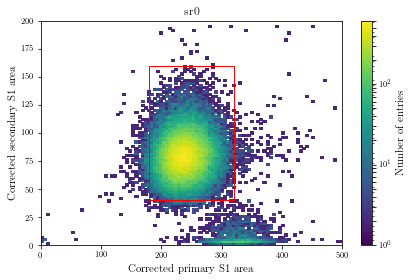

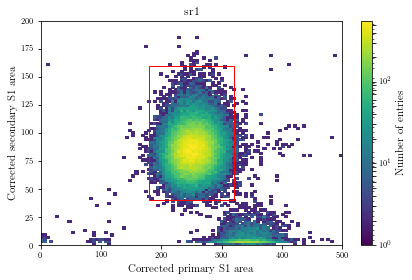

In [18]:
for dname, d in dsets.items():
    Histdd(d['data']['cs1_a'], d['data']['cs1_b'],
           bins=(np.linspace(0, 500, 100), np.linspace(0, 200, 100))).plot(log_scale=True)
    draw_box(primary_area_cut, secondary_area_cut, edgecolor='red')
    plt.xlabel("Corrected primary S1 area")
    plt.ylabel("Corrected secondary S1 area")
    plt.title(dname)
    finish('selection_%s' % dname)

In [19]:
for d in dsets.values():
    # Apply area cut
    mask = (primary_area_cut[0] < d['data']['cs1_a'].values) & (
        d['data']['cs1_a'].values < primary_area_cut[1])
    mask &= (secondary_area_cut[0] < d['data']['cs1_b'].values ) & (
        d['data']['cs1_b'].values < secondary_area_cut[1])
    cut(d,  mask)

    # Normalize waveforms
    d['data']['waveform_area'] = d['waveforms'].sum(axis=0)
    d['waveforms'] /= d['data']['waveform_area'].values[np.newaxis, :]

# Process S1s

In [20]:
# import warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings('error')
alignment_options = dict(method='area_fraction', area_fraction=0.1)
proc = xs.MatrixProcessor(ts, alignment_options=alignment_options)
    
for d in dsets.values():
    prim_mask = select_primary(d['data']).values

    d['prim'] = dict(waveforms=d['waveforms'][:, prim_mask],
                     data=d['data'][prim_mask],
                     label='Primary S1 (32.2 keV)')
    d['secn'] = dict(waveforms=d['waveforms'][:, ~prim_mask],
                     data=d['data'][~prim_mask],
                     label='Secondary S1 (9.4 keV)')
    
    # Do the processing
    for q in d['prim'], d['secn']:
        q.update(proc.process(q['waveforms'], full=True))

In [21]:
stats.norm.cdf(-1), stats.norm.cdf(1)

(0.15865525393145707, 0.84134474606854293)

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


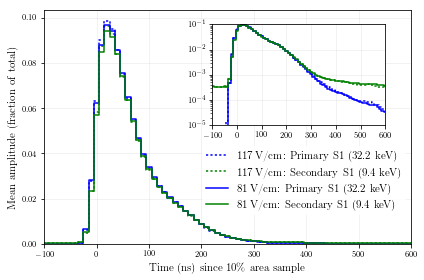

In [22]:
t_range = (-100, 600)

def comp_both():
    for dname, d in dsets.items():
        for q in 'prim', 'secn':
            plt.plot(ts, d[q]['average_waveform'],
                     drawstyle='steps-mid', 
                     linestyle={'sr1': '-', 'sr0': ':'}[dname],
                     color={'prim': 'b', 'secn': 'g'}[q],
                     label={'sr0': '\SI{117}{V/cm}', 'sr1': '\SI{81}{V/cm}'}[dname] + ': ' + d[q]['label'])
    plt.xlim(-200, 500)
    plt.ylim(1e-6, None)
    
inset_plot(comp_both, inset_log=True, inset_lims=(1e-5, 1e-1))
plt.tight_layout()
finish('s1_shape_comparison')


There is essentially no difference between SR0 and SR1. This indicates the drift field has at most a very limited influence on the S1.

The primary and secondary S1 also look very much alike. This indicates that Krypton S1s are large enough that statistical effects (SPE gain variation, alignment of S1s) play only a minor role in determining the average shape. Simulating them is probably still relevant, however, to ensure we can reproduce the variation S1 shapes. 

At early and late times, the secondary S1's average waveform flattens off. This indicates it is affected by outliers, for which the alignment has failed.

After 300 ns, even the primary S1s's average waveform flattens off somewhat. This could be due to PMT afterpulses. Excluding this range from the fit below does not change the result (probably because the KS-statistic I used is quite insensitive to disagreements in the tails). 

### Look for outliers / goodness of fit

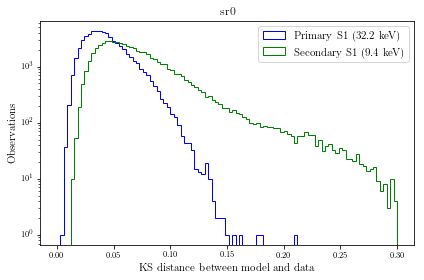

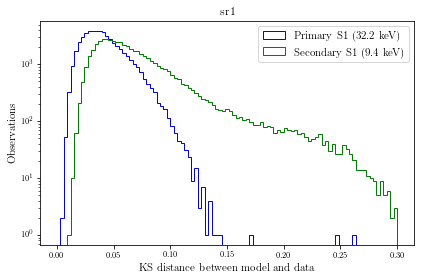

In [23]:
for dname, d in dsets.items():
    for q in 'prim', 'secn':
        plt.hist(d[q]['data_model_ks'], bins=np.linspace(0, 0.3, 100), histtype='step', label=d[q]['label'])
    plt.xlabel('KS distance between model and data')
    plt.ylabel('Observations')
    plt.yscale('log')
    plt.legend(loc='upper right')
    ks_cut = 0.15
    #labeled_vline(ks_cut, "Cut (primary only)", 10, color='red', textoffset=0.01)
    plt.title(dname)
    finish('gof_with_template_%s' % dname)

While it's expected that the average KS-distance is larger for the secondary than the primary S1 (as it has fewer photons), we see the secondary S1 has a large population of outliers. The primary S1 has only a handful of outliers. We'll focus on the primary S1 model below; for the moment, let's examine some of the outlying waveforms:

In [24]:
# mh = Histdd(prim['ks'], secn['ks'], bins=100)
# mh.plot(log_scale=True)
# # plt.ylim(0, 0.4)
# # plt.xlim(0, 0.2)

In [25]:
# # Verify alignment is done correctly
# for wv_i in range(10):
#     w = prim_wvs[:, wv_i]
#     plt.plot(ts, w, linestyle='steps-mid')
#     plt.plot(ts, mm[:, i_noshift + t_shifts[wv_i]//dt], linestyle='steps-mid')
#     plt.xlim(-150, 150)
#     plt.show()

In [ ]:
# Plot some of the worst offenders
for d in [dsets['sr1']['prim'], dsets['sr1']['secn']]:
    #for wv_i in np.random.randint(0, high=wvs.shape[1], size=3):
    print(d['label'])
    for wv_i in np.argsort(d['data_model_ks'])[-3:]:
        w = d['waveforms'][:, wv_i]
        plt.plot(ts, w, linestyle='steps-mid', label='Data')
        plt.plot(ts, d['model_matrix'][:, d['i_noshift'] + d['time_shifts'][wv_i]//dt], linestyle='steps-mid',
                label='Template')
        #plt.xlim(-500, 500)
        plt.xlabel("Time (ns) since center of gravity")
        plt.legend(loc='upper right')
        plt.ylabel("Amplitude (fraction of total)")
        finish('waveform_%d' % wv_i)
    

For the primary S1, outliers have a large secondary signal merged in, perhaps a big afterpulse, a single electron, or a combination of these. It could actually be the secondary Kr S1, though then the secondary Kr S1 as identified by pax has to arise from some arifact.

The worst outliers for the secondary S1 seem to be caused by large afterpulses from the primary S1, messing up the alignment.

### Remove outliers, recompute primary S1

In [27]:
# prim_outlier_mask = prim['ks'] < ks_cut
# prim_wvs = prim_wvs[:, prim_outlier_mask]

In [28]:
# old_model = prim['mean_template']

In [29]:
# plabel = prim['label']
# prim = doit(prim_wvs)
# prim['label'] = plabel

In [30]:
# (~prim_outlier_mask).sum()/len(prim_outlier_mask)

In [31]:
# np.sum(True ^ prim_outlier_mask)

In [32]:
# len(prim_outlier_mask)

Since we remove 3 outliers on ~50k waveforms, the difference is essentially neglgible, we need not have bothered recomputing the waveform.

In [33]:
# plt.plot(ts, prim['mean_template'], label='Template')
# plt.plot(ts, old_model - prim['mean_template'], label='Difference')
# plt.legend(loc='upper right')
# plt.ylim(1e-11, None)
# plt.yscale('log')

### Extract n_sampler

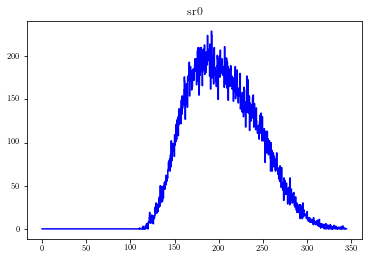

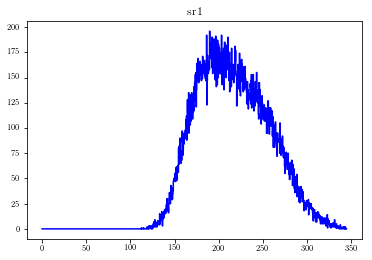

In [34]:
dpe_fraction=0.16

for dname, d in dsets.items():
    x = np.linspace(0, 400, 1000)
    h1 = Hist1d(d['prim']['data']['area'].values, xs.utils.centers_to_edges(x))
    h1.bin_edges /= (1 + dpe_fraction)
    h1.plot()
    d['prim']['n_sampler'] = h1.get_random
    plt.title(dname)
    plt.show()    

# Model

In [35]:
q = np.load('../spe_pulse_shape/x1t_sr1_spe.npz')
spe_y = q['ys']
spe_t = q['ts']
spe_y_cum = np.cumsum(spe_y)

spe_pulse = interpolate.interp1d(spe_t, spe_y_cum, 
                                 kind='linear', bounds_error=False, fill_value=(0, 1))

def simulate_s1s(n_sampler, n_photons=int(1e7), 
                 ts=ts,
                 t1=3.1, t3=24, fs=0.2, tts=3, **kwargs):
    """Return wv_matrix for simulated S1s consisting of n_photons in total
     * wv_matrix and time_matrix have shape (n_samples, n_s1s). t_shift_vector has shape (n_s1s).
     * wv_matrix contains amplitude, time_matrix contains center time of digitizer bin to which amplitude applies
     * t_shift_vector contains, for each S1, the time shift applied to align it. 
       e.g. for alignment on maximum, the time between the interaction time and the maximum time.
    """
    kwargs.setdefault('alignment_options', alignment_options)
    kwargs.setdefault('spe_pulse', spe_pulse)
    times = np.zeros(n_photons)
    
    # Singlet/triplet decay
    n_singlets = np.random.binomial(n=n_photons, p=fs)
    times += np.concatenate([
        np.random.exponential(t1, n_singlets),
        np.random.exponential(t3, n_photons - n_singlets)
    ])
    np.random.shuffle(times)   # So we don't put all triplets in the later S1s..

    # PMT transition time spread / other effects
    times += np.random.normal(0, tts, size=n_photons)
    
    return xs.simulate_peak_waveforms(times, ts=ts, n_sampler=n_sampler, **kwargs)

In [36]:
# wv_matrix = simulate_s1s(n_photons=int(1e5), fs=0)
# for i in range(10):
#     plt.plot(ts, wv_matrix[:, i], linestyle='steps-mid')
#     plt.xlim(-500, 500)
# t_matrix, t_shifts = xeshape.utils.aligned_time_matrix(ts, wv_matrix)

(-100, 300)

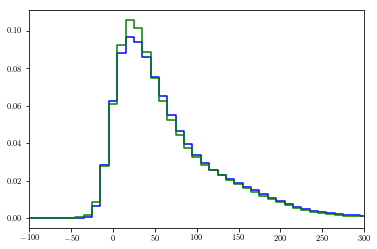

In [37]:
d = dsets['sr1']['prim']
wv_matrix = simulate_s1s(n_sampler=d['n_sampler'], fs=0, t3=40, tts=12)
res = proc.process(wv_matrix)
plt.plot(ts, d['average_waveform'], linestyle='steps-mid')
plt.plot(ts, res['average_waveform'], linestyle='steps-mid')
#plt.plot(ts, secn['mean_template'], linestyle='steps-mid')
plt.xlim(-100, 300)

# Fitting

In [38]:
#fit_range = (-100, 301)
#fit_mask = ((fit_range[0] <= ts)) & (ts <= fit_range[1])
fit_mask = np.ones_like(ts).astype(np.bool)

def gof(dset='sr1', s1type='prim', echo=True, **params):
    """Return goodness of fit of parameters. Parameters also selects which dataset to use.."""
    d = dsets[dset][s1type]
    data_template = d['average_waveform']
    sim_template = proc.process(simulate_s1s(n_sampler=d['n_sampler'], **params))['average_waveform']
    ks = np.abs(np.cumsum(sim_template[fit_mask]) - np.cumsum(data_template[fit_mask])).max()   
    if echo:
        print('ks=%0.5f, %s' % (ks, str(params)))
    return ks


In [39]:
# Don't trust regular minimizers for MC work: they will ask for gradients and you will  die
# Should use blueice integration.. too lazy
optresult = optimize.brute(
    lambda x: gof(fs=0, t3=x[0], tts=x[1]),
    #[50, 12],
    #bounds=[[20, 70], [5, 25]],
    #options=dict(maxfev=100),
    #method='Powell',
    # The first time you fit, obviously choose a wider range!
    #ranges=[(42.5, 44), (12, 13)],
    #ranges=[(42, 44), (12, 13.5)],
    ranges=[(41, 43), (12, 14)],
    Ns=10,
    finish=None,
)

ks=0.02249, {'fs': 0, 'tts': 12.0, 't3': 41.0}
ks=0.02212, {'fs': 0, 'tts': 12.0, 't3': 41.0}
ks=0.01983, {'fs': 0, 'tts': 12.222222222222221, 't3': 41.0}
ks=0.01796, {'fs': 0, 'tts': 12.444444444444445, 't3': 41.0}
ks=0.01553, {'fs': 0, 'tts': 12.666666666666666, 't3': 41.0}
ks=0.01349, {'fs': 0, 'tts': 12.888888888888889, 't3': 41.0}
ks=0.01152, {'fs': 0, 'tts': 13.111111111111111, 't3': 41.0}
ks=0.00969, {'fs': 0, 'tts': 13.333333333333334, 't3': 41.0}
ks=0.00767, {'fs': 0, 'tts': 13.555555555555555, 't3': 41.0}
ks=0.00679, {'fs': 0, 'tts': 13.777777777777779, 't3': 41.0}
ks=0.00831, {'fs': 0, 'tts': 14.0, 't3': 41.0}
ks=0.02171, {'fs': 0, 'tts': 12.0, 't3': 41.222222222222221}
ks=0.01947, {'fs': 0, 'tts': 12.222222222222221, 't3': 41.222222222222221}
ks=0.01736, {'fs': 0, 'tts': 12.444444444444445, 't3': 41.222222222222221}
ks=0.01456, {'fs': 0, 'tts': 12.666666666666666, 't3': 41.222222222222221}
ks=0.01285, {'fs': 0, 'tts': 12.888888888888889, 't3': 41.222222222222221}
ks=0.01057

In [40]:
optresult

array([ 41.88888889,  13.55555556])

In [41]:
len(dsets['sr1']['prim']['data'])

52881

In [42]:
#D = 0.00552
D = 5.6e-3
c_alpha = (-0.5 * np.log(0.5/2))**0.5
c_alpha**2 * 2 / D**2

44205.8150867312

In [43]:
d = dsets['sr1']['prim']
sim_wvs = proc.process(simulate_s1s(n_sampler=d['n_sampler'], n_photons=int(1e7),
                                    fs=0, t3=optresult[0], tts=optresult[1]),
                       full=True)

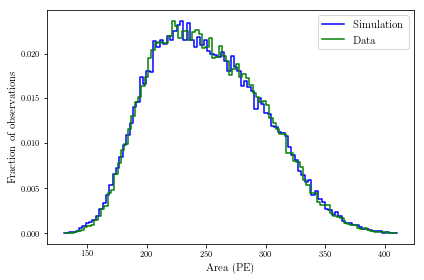

In [44]:
h1 = Hist1d(sim_wvs['areas'] * 10, bins=100)
#Hist1d(d['areas'] * 10, bins=h1.bin_centers).plot()
h2 = Hist1d(d['data']['s1'].values, bins=h1.bin_centers)
for h, label in zip([h1, h2], ['Simulation', 'Data']):
    plt.plot(h.bin_centers, h.normalized_histogram, linestyle='steps-mid', label=label)
plt.xlabel("Area (PE)")
plt.ylabel("Fraction of observations")
plt.legend(loc='upper right')
finish('area_comparison')

In [45]:
np.median(sim_wvs['areas']) * 10 / np.median(d['data']['s1'].values)

0.99807511465941623

In [46]:
def delta_pulse(ts):
    y = np.zeros_like(ts)
    y[ts>0] = 1
    return y
sim_wvs_delta_pulse = proc.process(simulate_s1s(n_sampler=d['n_sampler'], n_photons=int(1e7),
                                                spe_pulse=delta_pulse,
                                                fs=0, t3=optresult[0], tts=optresult[1]),
                       full=True)

In [47]:
from pax import configuration
pax_config = configuration.load_configuration('XENON1T')

y = np.cumsum(pax_config['WaveformSimulator']['pe_pulse_ys'])
y /= y[-1]
old_pulse = interpolate.interp1d(pax_config['WaveformSimulator']['pe_pulse_ts'], y, 
                                 kind='linear', bounds_error=False, fill_value=(0, 1))

sim_wvs_old = proc.process(simulate_s1s(n_sampler=d['n_sampler'], fs=0, n_photons=int(2e6),
                                        t3=pax_config['WaveformSimulator']['s1_decay_time'], 
                                        spe_pulse=old_pulse,
                                        tts=pax_config['WaveformSimulator']['pmt_transit_time_spread']),
                           full=True)

In [48]:
d['wv_matrix'].shape, sim_wvs['wv_matrix'].shape

((251, 52881), (251, 46107))

Simulate, write, load, process, and load the processed data... Here this goes at 5000 S1s/sec (on my laptop).

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


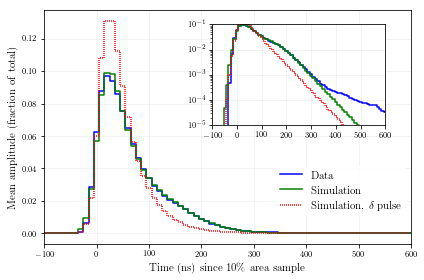

In [49]:
def bla():
    plt.plot(ts, d['average_waveform'], 
             linestyle='steps-mid', label='Data')
    plt.plot(ts, sim_wvs['average_waveform'],
             linestyle='steps-mid', label='Simulation')
    plt.plot(ts, sim_wvs_delta_pulse['average_waveform'],
             drawstyle='steps-mid', dashes=(0.5, 0.5),
             label='Simulation, $\delta$ pulse')
#     plt.plot(ts, sim_wvs_old['average_waveform'],
#              drawstyle='steps-mid',
#              label='Simulation, current model')
    plt.xlim(-50, 400)
    
inset_plot(bla, inset_log=True, inset_lims=(1e-5, 1e-1))
finish('s1_shape_fit')

What went wrong in my SR0 S1 shape analysis (https://github.com/XENON1T/pax/pull/524)? Most importantly, looked at secondary S1. You get the right model, but the widths will seem terrible because of the afterpulse contamination from the primary S1.
  
  

In [50]:
# from pax import configuration
# ap_conf = configuration.load_configuration('pmt_afterpulsing')
# for name, c in ap_conf['WaveformSimulator']['each_pmt_afterpulse_types'][126].items():
#     print(c)

# Compare widths

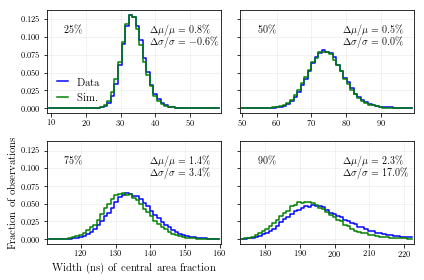

In [51]:
f, axes = plt.subplots(2, 2, sharey=True)
axes = axes.ravel()

def robust_std(x):
    return (np.percentile(x, 100 * stats.norm.cdf(1)) - 
            np.percentile(x, 100 * stats.norm.cdf(-1)))/2

for af_i, af in enumerate([0.25, 0.5, 0.75, 0.9]):
    ax = axes[af_i]
    plt.sca(ax)
        
    bins = dict()
    means = []
    stds = []
    for q, label, color in zip((d, sim_wvs), ('Data', 'Sim.'), 'bg'):
        x = q['fraction_area_width'][af] * 10
        means.append(x.mean())
        # Use robust estimate of std, don't want to get massive disagreement because of a few outliers
        stds.append(robust_std(x))
        
        if af not in bins:
            # Figure out sensible bins:
            mu = x.mean()
            bins[af] = np.linspace(mu - 25, mu + 25, 50)
        h1 = Hist1d(x, bins[af]);
        
        plt.plot(h1.bin_centers, h1.normalized_histogram, 
                 color=color, linestyle='steps-mid',
                 label=label)
        
#     ytext = h1.normalized_histogram.max() * 0.35
#     plt.plot(means, 0.025 * np.ones(2), c='k')
#     plt.text(np.mean(means), 0, "%0.2f ns" % abs(means[1] - means[0]),
#              horizontalalignment='center')
    
    plt.text(0.59, 0.85,
             (r'$\Delta \mu / \mu = %0.1f \%%$' + "\n" + r'$\Delta \sigma / \sigma = %0.1f \%%$') % (
                -100 * (means[1] - means[0])/means[1],
                -100 * (stds[1] - stds[0])/stds[1]),
             transform=ax.transAxes,
             verticalalignment='top',
            )
        
    plt.text(0.1, 0.85, 
             "%d\%%" % (af * 100),
             transform=ax.transAxes,
             verticalalignment='top',
             #horizontalalignment='center'
            )
    
    plt.grid(alpha=0.2)
    plt.xlim(h1.bin_edges[0], h1.bin_edges[-1])
    
axes[0].legend(loc='lower left', handlelength=1, frameon=False)
axes[2].set_ylabel("Fraction of observations")
axes[2].set_xlabel("Width (ns) of central area fraction")
#plt.ylabel("Fraction of total")
#plt.ylim(0, plt.ylim()[-1] * 1.2)
#plt.yscale('log')
plt.tight_layout()
plt.gcf().subplots_adjust(hspace=0.2, wspace=0.05)
finish('s1_width_comparison')

Positive: data is larger. Negative: simulation is larger.

Like to know two things: (1) do we match in a variable you didn't fit (2) can we match variations in data.
Figure X shows answer is 'yes to both'.


In [52]:
bla = proc.process(simulate_s1s(n_dist=stats.randint(69, 70), 
                          n_photons=int(1e6),
                          fs=0, t3=optresult[0], tts=optresult[1]),
                       full=True)

TypeError: simulate_s1s() missing 1 required positional argument: 'n_sampler'

In [ ]:
robust_std(sim_wvs['fraction_area_width'][0.5] * 10)

In [ ]:
robust_std(bla['fraction_area_width'][0.5] * 10)

In [ ]:
# plt.scatter(bla['areas'] * 10, 
#             bla['fraction_area_width'][0.5] * 10, marker='.')

In [ ]:
x = np.linspace(0, 5000, 100)
ap_hist = Hist1d(bins=x)
for name, c in ap_conf['WaveformSimulator']['each_pmt_afterpulse_types'][126].items():
    tps = c['time_parameters']
    if c['time_distribution'] == 'normal':
        dist = stats.norm(loc=tps['loc'], scale=tps['scale'])
    elif c['time_distribution'] == 'uniform':
        dist = stats.uniform(tps['low'], tps['high'])
    #print(c['time_parameters'], c['time_distribution'])
    y = np.diff(dist.cdf(x)) * c['p']
    ap_hist += y
    plt.plot((x[1:] + x[:-1])/2, y, label='' if label.startswith('Uniform'))
ap_hist.plot(c='k', label='Total')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

In [ ]:
ap_hist.histogram.sum()

According to the current afterpulse config, the total afterpulse probability is 1 - 2 % (it varies per PMT).

In [ ]:
for af in [0.25, 0.5, 0.75, 0.9]:
    wbins = np.arange(0, 251)
    for q, label, color in zip((d, sim_wvs), ('Data', 'Simulation'), 'bg'):
        h1 = Hist1d(q['fraction_area_width'][af] * 10, wbins);
        plt.plot(h1.bin_centers, h1.normalized_histogram, 
                 color=color, linestyle='steps-mid',
                 label=label if af == 0.25 else None)
    plt.text(h1.mean, min(h1.normalized_histogram.max() * 1.2, 0.7), "%d\%%" % (af * 100),
             horizontalalignment='center')
    
    plt.legend(loc='upper right')
plt.xlabel("Width (ns) of central area fraction")
plt.ylabel("Fraction of total")
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

In [ ]:
# for wv_i in np.random.choice(np.where((d['width_std'] > 70))[0], 5):
#     plt.plot(ts - d['time_shifts'][wv_i], d['waveforms'][:, wv_i], c='k', alpha=0.3, linestyle='steps-mid')
#     plt.plot(ts, sim_wvs['average_waveform'], c='b', linestyle='steps-mid')
#     plt.xlim(None, None)
#     plt.show()

In [ ]:
wbins = np.arange(50, 100)
for q in (d, sim_wvs):
    plt.hist(q['width_std'], wbins, histtype='step', normed=True);

In [ ]:
from scipy import stats
mu = 1
sigma = 0.5
x = np.linspace(-1, 3, 100)
dist = stats.truncnorm(-mu/sigma, float('inf'), loc=mu, scale=sigma)
plt.plot(x, dist.pdf(x))
plt.axvline(dist.mean(), color='r')

### Check if 50% area computation is the same

In [ ]:
a = dsets['sr1']['prim']['fraction_area_width'][0.5] * 10
b = dsets['sr1']['prim']['data']['s1_range_50p_area'].values
np.median(np.abs((a-b)/a))

In [ ]:
#1/data['run_number'] + data['event_number']

In [ ]:
np.in1d(data['left']

### Bla

In [ ]:
Histdd(data2['area'], data2['range_50p_area'], 
       bins=(np.linspace(0, 500, 100), 100)).plot(log_scale=True)

In [ ]:
(the SEs are binned based on the average SE width at their position, not based on their actual width (which is very stochastic))

# OLD JUNK

In [ ]:
raise ZeroDivisionError

In [ ]:
#get_params(dict())['hit_distribution']

In [ ]:
# class S1WaveformSource(xeshape.bi.WaveformSource):
#     def simulate_wv_matrix(self, n_events):
#         c = self.config
        
#         # Simulat a bit more photons than we need
#         n_photons = (c['hit_dist'].mean() + c['hit_dist'].std()) * n_events
        
#         wv_matrix = simulate_s1s(n_photons, **c)
#         return wv_matrix[:,:n_events]

# config = dict(
#     sources=[dict(name='Freddie')],
#     analysis_space=(('t', ts),),
#     default_source_class=S1WaveformSource,
#     n_events_for_model=int(1e3),
# )
# config.update(default_params)
# config['fs'] = 0

# OLD junk

In [ ]:
from pax import units
plt.hist(data['left'] * 10 * units.ns / units.ms, bins=np.linspace(0, 2.5, 100));
plt.yscale('log')

In [ ]:
mh = Histdd(data['left'] * 10 * units.ns / units.ms, 
            data['c_area'],
            bins=(np.linspace(0, 2.5, 100), np.linspace(0, 450, 100)))

mh.plot(log_scale=True)
#plt.yscale('log')
plt.xlabel("Time (ms) in event")
plt.ylabel("Corrected S1 Area (pe)")
x = 0.5
#t1 = plt.text(x, 4, "Few hits", backgroundcolor='white')
#t2 = plt.text(x, 20, "SE")
t3 = plt.text(x, 80, "9.4 keV")
t4 = plt.text(x, 250, "32 keV")
t5 = plt.text(1.5, 170, "Pile-up / early trigger", verticalalignment='center')
for t in [t1, t2, t3, t4, t5]:
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

#labeled_hline(50, "Cut below", 0.2, color='red', textoffset=10)
plt.tight_layout()

In [ ]:
prim_mask = select_primary(data)
for secondary in False, True:
    d = data[secondary ^ prim_mask]
    Histdd((d['center_time'] - 1 * units.ms) / units.us, 
           d['c_area'],
           bins=(np.linspace(0, 3, 100), 
                 np.logspace(1, 4, 100))).plot(log_scale=True)
        
    offset = 0.6
    if secondary:
        plt.axvspan(offset + 0.6, offset + 2, color='red', alpha=0.1)
        plt.text(offset + (0.6+2)/2, 1000, "Preselection\npreferred", horizontalalignment='center', color='red')

        plt.axhspan(*secondary_area_cut, color='blue', alpha=0.2)
        plt.text(0.2, 
                 np.exp(np.mean(np.log(secondary_area_cut))),
                 "Area\nsel.",
                 horizontalalignment='center', verticalalignment='center',
                 color='blue')
        
        plt.title("Secondary S1")
        
    else:
        #labeled_vline(offset, "Trigger offset", 1500, linestyle=':', textoffset = 0.1, color='r')

        plt.axhspan(*primary_area_cut, color='blue', alpha=0.2)
        plt.text(0.2, 
                 np.exp(np.mean(np.log(primary_area_cut))),
                 "Area\nsel.",
                 horizontalalignment='center', verticalalignment='center',
                 color='blue')
        
        t = plt.text(1, 700, "Merged with SE?")
        plt.title("Primary S1")
        
    plt.yscale('log')
    plt.xlabel("Center time (\si{\micro s}) since trigger time")
    plt.ylabel("Corrected S1 Area (pe)")
    plt.show()

In [ ]:
# plt.hist(data2['cs1_b'], bins=np.logspace(1, 4, 100))
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
hax.cuts.history(data2)

In [ ]:
plt.hist(data2['cs1_a'], np.logspace(0, 4, 100), histtype='step');
plt.hist(data2['cs1_b'], np.logspace(0, 4, 100), histtype='step');
plt.xscale('log')

In [ ]:
# pm.sum() / len(data2)

In [ ]:
hax.cuts.history(data2)

In [ ]:
def select_primary(data):
    return data['s1_a_center_time'] == data['center_time']

prim_mask = select_primary(data2)
for secondary in False, True:
    d = data2[secondary ^ prim_mask]
    Histdd((d['center_time'] - 1 * units.ms) / units.us, 
           d['area'],
           bins=(np.linspace(0, 3, 100), 
                 np.logspace(1, 4, 100))).plot(log_scale=True)
        
    offset = 0.6
    if secondary:
        plt.axvspan(offset + 0.6, offset + 2, color='red', alpha=0.2)
        plt.text(offset + (0.6+2)/2, 1000, "Preselection", horizontalalignment='center', color='red')

        plt.axhspan(*secondary_area_cut, color='blue', alpha=0.2)
        plt.text(0.2, 
                 np.exp(np.mean(np.log(secondary_area_cut))),
                 "Area\nsel.",
                 horizontalalignment='center', verticalalignment='center',
                 color='blue')
        
        plt.title("Secondary S1")
        
    else:
        labeled_vline(offset, "Trigger offset", 1500, linestyle=':', textoffset = 0.1, color='r')

        plt.axhspan(*primary_area_cut, color='blue', alpha=0.2)
        plt.text(0.2, 
                 np.exp(np.mean(np.log(primary_area_cut))),
                 "Area\nsel.",
                 horizontalalignment='center', verticalalignment='center',
                 color='blue')
        
        t = plt.text(1, 700, "Merged with SE?")
        plt.title("Primary S1")
        
    plt.yscale('log')
    plt.xlabel("Center time (\si{\micro s}) since trigger time")
    plt.ylabel("Area (pe)")
    plt.show()

In [ ]:
plt.hist((data['s1_a_center_time'] - 1 * units.ms) / units.us,
         bins=np.linspace(0, 3, 100), histtype='step');
plt.hist((data['s1_b_center_time'] - 1 * units.ms) / units.us,
         bins=np.linspace(0, 3, 100), histtype='step');
plt.yscale('log')

In [ ]:
(data['s1_b_center_time'] - data['s1_a_center_time']).min()